In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm


# from tensorflow.contrib.kfac.python.ops.utils import fwd_gradients
import seaborn as sns

slim = tf.contrib.slim
ds = tf.contrib.distributions


from functools import reduce
from operator import mul


import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import utils
ds = tf.contrib.distributions


/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%%javascript
require(
        ["notebook/js/outputarea"],
        function (oa) {
            oa.OutputArea.auto_scroll_threshold = -1;
            console.log("Setting auto_scroll_threshold to -1");
        });

<IPython.core.display.Javascript object>


## Hyperparameters

In [4]:
params = dict(
    batch_size=256,
    unl_batch_size = 256,
    learning_rate=3e-4,
    beta1=0.5,
    epoch=1200,
    epsilon=1e-8,
    max_iter=20000,
    viz_every=1000,
    z_dim=128,
    x_dim=2,
    optimizer='rmsprop', # rmsprop sgd sga
    seed = 122524,
    nabla = 0,
    reg_w = 10. 
)
rng = np.random.RandomState(params['seed'])  # seed labels

## Data Creation

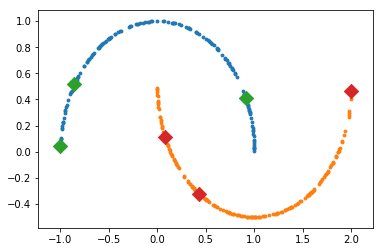

In [5]:
labeled =3
x,y=make_moons(n_samples=1000, shuffle=True, noise=0.00, random_state=rng.randint(2**10))
trainx, testx, trainy, testy = train_test_split(x, y, test_size=0.33, random_state=rng.randint(2**10))
trainx_unl = trainx.copy()

inds = rng.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:labeled])
    tys.append(trainy[trainy == j][:labeled])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys

nr_batch_train = trainx.shape[0] // params['batch_size']
nr_batch_test = testx.shape[0] // params['batch_size']

utils.scatter_2_class(testx,testy,s=8)
# utils.scatter_2_class(trainx_unl,np.ones(trainx_unl.shape[0]),s=1,c='k')
utils.scatter_2_class(trainx,trainy,marker = 'D',s=100)
plt.show()


In [6]:
def generator(z, output_dim=2, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("generator", reuse=reuse):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

In [7]:
tf.reset_default_graph()

## Build model

In [8]:
unl_dataset = tf.data.Dataset.from_tensor_slices(trainx_unl)
unl_dataset = unl_dataset.shuffle(10000).repeat().batch(params['unl_batch_size'])

train_dataset = tf.data.Dataset.from_tensor_slices((trainx, trainy))
train_dataset = train_dataset.shuffle(10000).repeat().batch(params['batch_size'])

test_dataset = tf.data.Dataset.from_tensor_slices((testx, testy))
test_dataset = test_dataset.repeat().batch(params['batch_size'])

iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
next_element, next_label = iterator.get_next()
training_init_op = iterator.make_initializer(train_dataset)
validation_init_op = iterator.make_initializer(test_dataset)

iterator_unl = unl_dataset.make_one_shot_iterator()
next_unl = iterator_unl.get_next()

In [9]:
data = tf.cast(next_unl,tf.float32)
noise = tf.random_normal(shape=[params['batch_size'],params['z_dim']])
# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

optimizer = tf.train.RMSPropOptimizer(params['learning_rate'], use_locking=True)

d_grads = tf.gradients(loss, disc_vars)
g_grads = tf.gradients(-loss, gen_vars)

variables = disc_vars + gen_vars
grads = d_grads + g_grads
    
reg = 0.5 * sum(tf.reduce_sum(tf.square(g)) for g in grads)
Jgrads = tf.gradients(reg, variables)

apply_vec = [(g + params['reg_w'] * Jg, v)for (g, Jg, v) in zip(grads, Jgrads, variables) if Jg is not None]

with tf.control_dependencies([g for (g, v) in apply_vec]):
    train_op = optimizer.apply_gradients(apply_vec)    

## Vector Field

In [10]:
perturb = tf.random_normal([params['batch_size'],params['z_dim']], mean=0, stddev=1)
perturb = tf.nn.l2_normalize(perturb, dim=[1])
z_pert = noise + 1e-1* perturb
samples_perturb = generator(z_pert, output_dim=params['x_dim'], reuse=True)

In [11]:
# samples_perturb = generator(noise, output_dim=params['x_dim'], reuse=True)

In [12]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

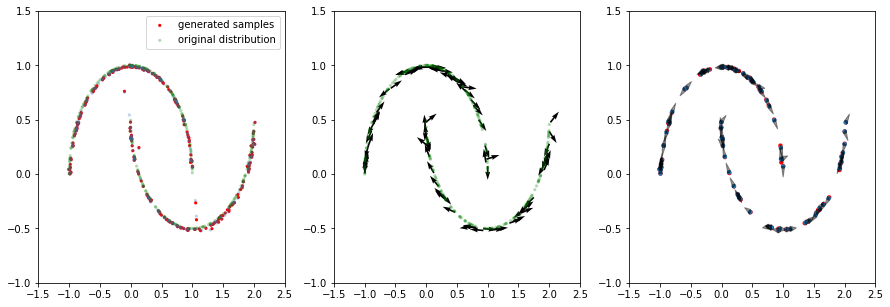

KeyboardInterrupt: 

In [17]:
fs = []
frames = []
np_samples = []
n_batches_viz = 1
viz_every = params['viz_every']
n_quiver = 80

yy = np.vstack([sess.run(data) for _ in range(n_batches_viz)])

for i in tqdm(range(params['max_iter']+1)):
    f, _= sess.run([[loss], train_op])

    fs.append(f)
    if (i) % viz_every == 0:
        gen_samples, gen_samples_pert = sess.run([samples,samples_perturb])
#         np_samples.append(gen_samples)
#         gen_samples_pert = np.vstack([sess.run(samples_perturb) for _ in range(n_batches_viz)])
#         np_samples.append(gen_samples_pert)
#         xx, yy = sess.run([samples, data])
        
        xx = gen_samples
        zz = gen_samples_pert
#         fig = plt.figure(figsize=(5,5))
#         plt.scatter(xx[:, 0], xx[:, 1], edgecolor='none',s=10)
#         plt.scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10)
#         plt.scatter(zz[:, 0], zz[:, 1], edgecolor='none',s=15)
#         plt.axis('off')
#         plt.show()
        
        
        uu = zz - xx 
        norm = np.linalg.norm(uu,axis=1,keepdims=1)
        uu_n = uu / (norm * np.ones([1,2]))
        fig = plt.figure(figsize=(15,5))
        plt.subplot(131)
        plt.scatter(xx[:, 0], xx[:, 1], edgecolor='none',s=10,c='r')
        plt.scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10,alpha = 0.3)
        plt.scatter(zz[:, 0], zz[:, 1], edgecolor='none',s=10,alpha = 0.3)
        plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])
        plt.legend(['generated samples','original distribution'])
#         plt.axis('off')
#         print(uu_n)
        plt.subplot(132)
        plt.quiver(xx[:n_quiver, 0], xx[:n_quiver, 1],  uu_n[:n_quiver,0], uu_n[:n_quiver,1])
#         plt.quiver(xx[:, 0], xx[:, 1],  np.ones_like(xx[:, 0]), np.ones_like(xx[:, 0]))
        plt.scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10,alpha = 0.3)


        plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])
#         plt.axis('off')
        
#         plt.subplot(133)
#         plt.quiver(xx[:n_quiver, 0], xx[:n_quiver, 1],  uu[:n_quiver,0], uu[:n_quiver,1])
#         plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])
#         plt.scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10,alpha = 0.3)

        
        
        plt.subplot(133)
#         plt.quiver(xx[:n_quiver, 0], xx[:n_quiver, 1],  uu[:n_quiver,0], uu[:n_quiver,1],alpha=0.4)
        plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])
        plt.scatter(xx[:n_quiver, 0], xx[:n_quiver, 1], edgecolor='none',s=20,c='r')
        plt.scatter(zz[:n_quiver, 0], zz[:n_quiver, 1], edgecolor='none',s=20)
#         plt.axis('off')
#         for i in range(xx.shape[0]):
        for i in range(n_quiver):
            plt.arrow(xx[i,0], xx[i,1], uu[i,0], uu[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k',alpha=0.4,color='r')
        
        plt.show()


In [16]:
xls=[]; jls =[]
reg = []
sess.run(training_init_op)
for i in tqdm(range(params['epoch'])):
    xl,jl, _, acc,l2 = sess.run([xloss, j_loss, train_op, accuracy,_l2])
    xls.append(xl); jls.append(jl); reg.append(l2)
    if i % 100 == 0:
        print("Epoch: {}, loss: {:.5f}, training accuracy: {:.2f}%".format(i, xl, acc * 100))

    if i % 200 == 0:
        sess.run(validation_init_op)
        avg_acc = 0; pred = []; valid_iters = nr_batch_test; nabla_datapoint = []
        deltax = []
        for i in range(valid_iters):
            acc,p,dl = sess.run([accuracy,prediction,jacob_norm])
            avg_acc += acc
            pred.append(p); nabla_datapoint.append(dl)
        print("Average validation set accuracy over {} iterations is {:.2f}%".format(valid_iters,(avg_acc / valid_iters) * 100))
        pred = np.concatenate(pred); _nabla = np.concatenate(nabla_datapoint)
        sess.run(training_init_op)


NameError: name 'xloss' is not defined

In [ ]:
plt.figure(1,figsize=(18,5))
plt.subplot(131)
utils.scatter_2_class(testx,pred,s=8)
utils.scatter_2_class(trainx,trainy, marker='D',s=100)
plt.legend(['_','_','labeled datapoint'])
plt.subplot(132)
plt.scatter(testx[:,0],testx[:,1], s=30, c=_nabla, alpha=1.,cmap='Reds',norm=None,vmin=0, vmax=500,linewidths=0.1,edgecolors='b')
plt.colorbar()
# plt.title('nabla loss')
plt.legend(['nabla loss'])
plt.subplot(133)                      
plt.plot(xls)
plt.plot(jls)
plt.plot(reg)
# plt.ylim([10^-2,10^(-3)])
xlabel('epochs')
plt.legend(['xentropy loss', 'nabla loss'])

plt.show()

In [ ]:
# utils.scatter_2_class(testx,pred,s=8)
utils.scatter_2_class(deltax,pred,s=8)
plt.show()